# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

### Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### План работы

1. **Предобработка данных**
   
2. **Выбор модели**:
   - Использование моделей, таких как LightGBM, CatBoost, или LinearRegression.

   
3. **Оценка и настройка гиперпараметров**:
   - Оптимизация гиперпараметров с помощью GridSearchCV.

   
4. **Оценка качества модели**
   


### Признаки:

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

Целевой признак:

- **Price** — цена (евро)


In [1]:
# Отбор информативных признаков

cols = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
        'Kilometer', 'FuelType', 'Brand', 'Repaired']

## Подготовка данных

In [2]:
%pip install phik -q
%pip install category_encoders -q
%pip install catboost -q
%pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
# импорт инструментов для анализа
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

# модели
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

# инструменты для обучения
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import (
    MinMaxScaler, 
    StandardScaler, 
    OneHotEncoder)
    
from sklearn.impute import SimpleImputer

# метрики
from sklearn.metrics import mean_squared_error, make_scorer

#Для оценки важности признаков
from sklearn.inspection import permutation_importance

In [3]:
sns.set_style('darkgrid') # Установка стиля графиков по умолчанию

sns.set(rc={'figure.figsize':(10, 6)}) # Размер графиков по умолчанию

In [5]:
path = r"C:\Users\79088\Documents\datasets\autos.csv"

df = pd.read_csv(path)

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
# Создание таблицы пустых значений

temp = dict()

for name in df.columns:
    count_null_values = sum(df[name].isna())
    
    proportion_null_values = count_null_values / df.shape[0]
    
    persent_null_values = round(proportion_null_values, 2) * 100
    
    temp[name] = persent_null_values
    
res = pd.DataFrame(data=temp.values(), index=temp.keys(), columns=['% null values'])

In [9]:
res.sort_values(by='% null values', ascending=False)

,% null values
Repaired,20.0
VehicleType,11.0
FuelType,9.0
Gearbox,6.0
Model,6.0
DateCrawled,0.0
Price,0.0
RegistrationYear,0.0
Power,0.0
Kilometer,0.0


-- Приемлемый уровень нулевых значений. Можно будет заменить на модальное значение на этапе построения паплайна для модели

### Обработка типов данных

In [10]:
# Преобразование и Удаление излишних данных о времени

df.DateCrawled = pd.to_datetime(df.DateCrawled).dt.date
df.DateCreated = pd.to_datetime(df.DateCreated).dt.date
df.LastSeen = pd.to_datetime(df.LastSeen).dt.date

### Анализ уникальных значений

In [11]:
# Уникальные значения в колонках типа объект

temp = df.select_dtypes(include='object').columns
print('Уникальные значения в колонках типа объект:\n\n')

for name in temp:
    length_unique_values = len(df[name].unique())
    
    if length_unique_values < 20:
        print(f"{name}: {df[name].unique()}\n")

Уникальные значения в колонках типа объект:


VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Gearbox: ['manual' 'auto' nan]

FuelType: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

Repaired: [nan 'yes' 'no']



-- Нужно только заполнить пустые значения. 

In [12]:
df = df.fillna('no_information') # Заполнение заглушкой пустых значений

-- "petrol" используется в британском английском, а "gasoline" — в американском английском. Можно их объединить

In [13]:
# Замена значений
df.FuelType = df.FuelType.replace('petrol', 'gasoline')

In [14]:
df.FuelType.unique()

array(['gasoline', 'no_information', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

### Удаление дубликатов

In [15]:
sum_deleted_row = 0

In [16]:
# дубликаты
df[df.duplicated()] 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
8803,2016-03-12,1700,sedan,2004,manual,0,mondeo,150000,9,gasoline,ford,no_information,2016-03-12,0,53520,2016-03-12
9413,2016-03-21,3399,small,2002,manual,90,one,150000,8,gasoline,mini,no,2016-03-21,0,45739,2016-03-23
10699,2016-03-22,1800,bus,1997,auto,100,vito,150000,8,gasoline,mercedes_benz,no,2016-03-22,0,22885,2016-03-22
10773,2016-03-24,16000,sedan,2014,auto,150,a3,20000,3,gasoline,audi,no,2016-03-24,0,10115,2016-03-24
10912,2016-03-26,0,coupe,1991,manual,156,other,150000,6,gasoline,toyota,no_information,2016-03-26,0,65929,2016-04-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354274,2016-03-12,7399,wagon,2006,auto,96,a4,125000,12,gasoline,audi,no,2016-03-12,0,45699,2016-03-29
354281,2016-03-07,6500,sedan,1993,auto,286,5er,150000,1,gasoline,bmw,no,2016-03-07,0,81249,2016-04-05
354300,2016-03-26,8940,sedan,2009,manual,80,golf,60000,8,gasoline,volkswagen,no,2016-03-26,0,27299,2016-04-06
354317,2016-03-19,5990,small,2009,manual,86,ibiza,90000,6,gasoline,seat,no,2016-03-19,0,51371,2016-03-24


In [17]:
cnt_dup = sum(df.duplicated())
print(f"Кол-во дубликатов: {cnt_dup}")

alls = df.shape[0]
print(f"Кол-во записей: {alls}")

Кол-во дубликатов: 6832
Кол-во записей: 354369


In [18]:
# Удаление явных дубликатов
df = df.drop_duplicates() 

sum_deleted_row += cnt_dup # сумма удалённых строк

In [19]:
cnt_dup = sum(df.duplicated())
print(f"Кол-во дубликатов после удаления: {cnt_dup}")

alls = df.shape[0]
print(f"Кол-во записей после удаления: {alls}")

Кол-во дубликатов после удаления: 0
Кол-во записей после удаления: 347537


## Статистический анализ данных

In [20]:
# Признаки для статистического анализа
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24,480,no_information,1993,manual,0,golf,150000,0,gasoline,volkswagen,no_information,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,no_information,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_information,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06


### Цена (целевой признак) 

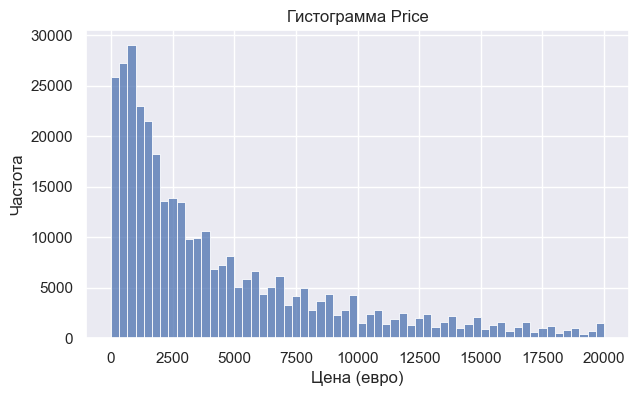

In [21]:
plt.figure(figsize=(7, 4)) 
sns.histplot(data=df['Price'], bins=60)
plt.title(f'Гистограмма Price')
plt.xlabel('Цена (евро)')
plt.ylabel('Частота');

-- Чаще всего продаются машины с наиболее низкими ценами. Вероятно, естественное положение дел для рынка автомобилей.


-- Странным является только наличие большого кол-ва авто со слишком низкой ценой (ниже 50 евро), что не естественно для рынка.

Их стоит удалить чтобы они не мешали предсказывать реальную цену авто. 

В противном случае некоторые пользователи могут получить негативный опыт, при использовании приложения, от того что их машина стоит абсолютный 0.

In [22]:
df = df.loc[df['Price']>=50]

### Тип кузова

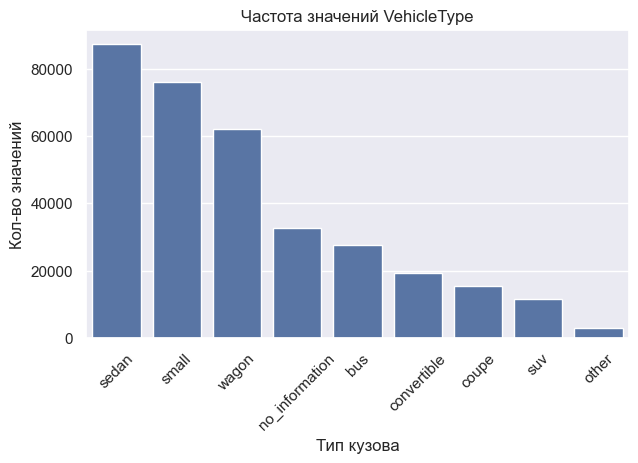

In [23]:
plt.figure(figsize=(7, 4)) 
sns.countplot(data=df, x='VehicleType', order=df['VehicleType'].value_counts().index)
plt.title(f'Частота значений VehicleType')
plt.ylabel('Кол-во значений')
plt.xlabel('Тип кузова')
plt.xticks(rotation=45);

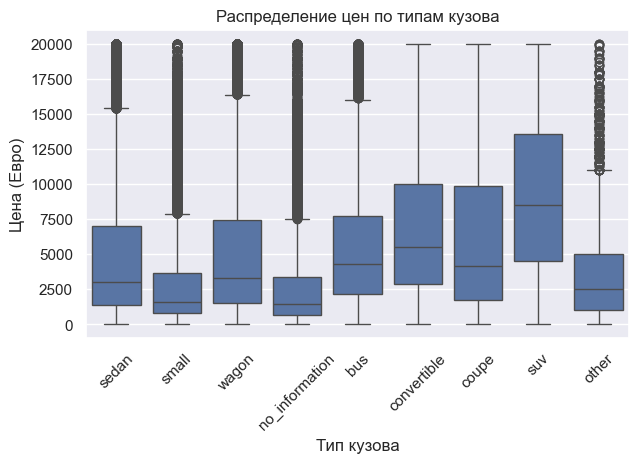

In [24]:
plt.figure(figsize=(7, 4)) 
sns.boxplot(data=df, x='VehicleType', y='Price', order=df['VehicleType'].value_counts().index)
plt.title('Распределение цен по типам кузова')
plt.xlabel('Тип кузова')
plt.ylabel('Цена (Евро)')
plt.xticks(rotation=45) 
plt.show()

### Год регистрации авто

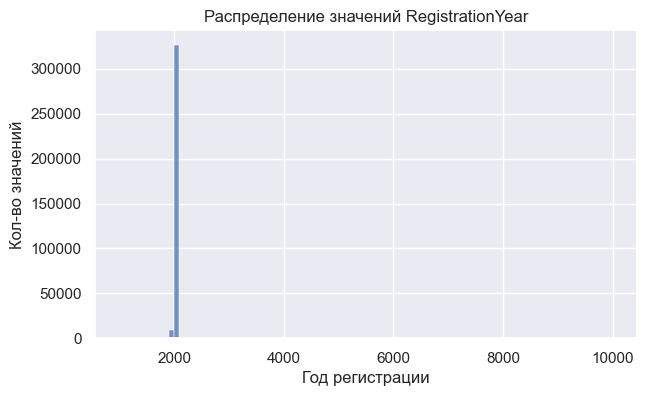

In [25]:
plt.figure(figsize=(7, 4)) 
sns.histplot(data=df, x='RegistrationYear', bins=100)
plt.title(f'Распределение значений RegistrationYear')
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во значений');

Очевидные выбросы в признаке "год регистрации". Нужно корректировать

In [26]:
summ = df.loc[df['RegistrationYear']>2016, 'RegistrationYear'].shape[0] + \
    df.loc[df['RegistrationYear']<1970, 'RegistrationYear'].shape[0]

print('Кол-во некорректных строк:')
print(summ)

Кол-во некорректных строк:
14688


In [27]:
# Удаление строк с ошибками в значениях
df = df.loc[df['RegistrationYear']>1970]
df = df.loc[df['RegistrationYear']<2017]

sum_deleted_row += summ # сумма удалённых строк

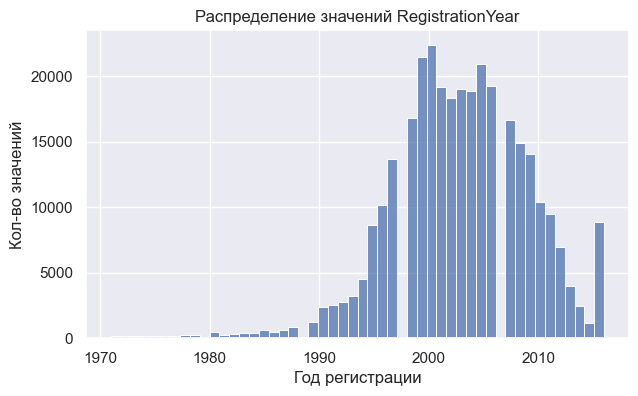

In [28]:
plt.figure(figsize=(7, 4)) 
sns.histplot(data=df['RegistrationYear'], bins=50)
plt.title(f'Распределение значений RegistrationYear')
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во значений');

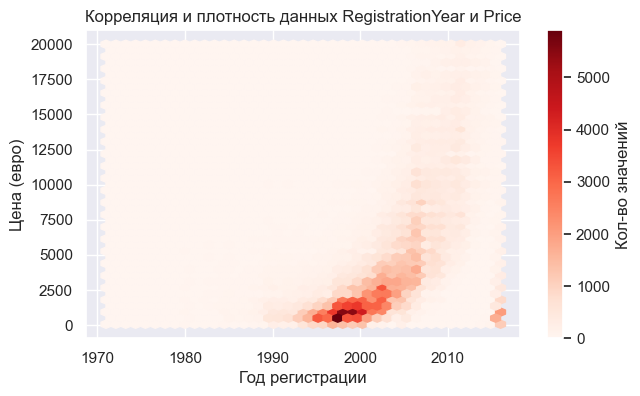

In [29]:
plt.figure(figsize=(7, 4)) 
plt.hexbin(df['RegistrationYear'], df['Price'], gridsize=40, cmap='Reds')
plt.colorbar(label='Кол-во значений')
plt.xlabel('Год регистрации')
plt.ylabel('Цена (евро)')
plt.title('Корреляция и плотность данных RegistrationYear и Price');

Здесь видна аномалия с данными после 2016 года. Нужно корректировать.

### Тип коробки передач

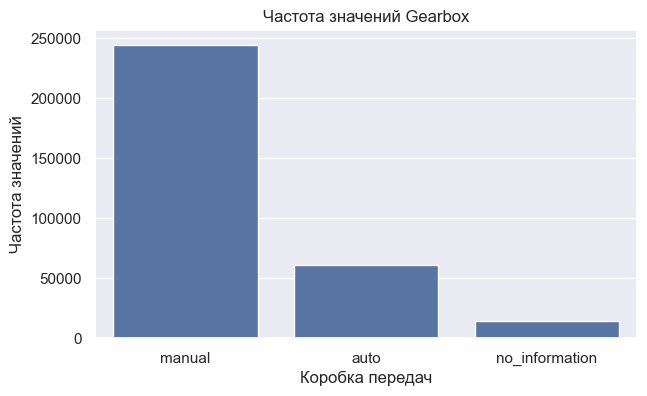

In [30]:
plt.figure(figsize=(7, 4)) 
sns.countplot(data=df, x='Gearbox')
plt.title(f'Частота значений Gearbox')
plt.xlabel('Коробка передач')
plt.ylabel('Частота значений');

### Мощность двигателя

In [31]:
summ = df[df.Power > 500].shape[0] + df[df.Power < 30].shape[0]

print('Кол-во некорректных строк:')
print(summ)

# Удаление строк с ошибками в значениях
df = df[df.Power < 500]
df = df[df.Power > 30]

sum_deleted_row += summ # сумма удалённых строк

Кол-во некорректных строк:
32218


 Значения мощности двигателя более 500 л.с. и менее 30 л.с. считаются нереалистичными для двигателя обычных машин, поэтому они были удалены.

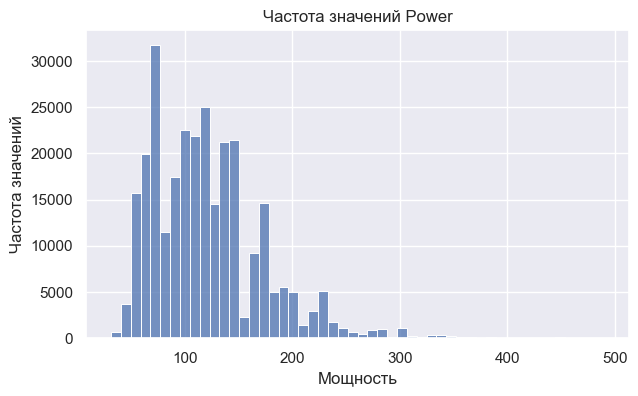

In [32]:
plt.figure(figsize=(7, 4)) 
sns.histplot(data=df, x='Power', bins=50)
plt.title(f'Частота значений Power')
plt.xlabel('Мощность')
plt.ylabel('Частота значений');

### Модель 

In [33]:
top_ten = df.Model.value_counts()[:10].index.tolist()

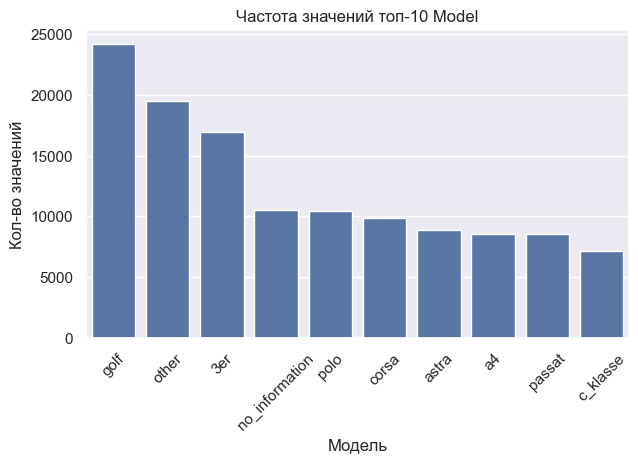

In [34]:
plt.figure(figsize=(7, 4)) 
sns.countplot(data=df.loc[df['Model'].isin(top_ten)], x='Model', 
              order=df.loc[df['Model'].isin(top_ten)].Model.value_counts().index)
plt.title(f'Частота значений топ-10 Model')
plt.ylabel('Кол-во значений')
plt.xlabel('Модель')
plt.xticks(rotation=45);

### Пробег

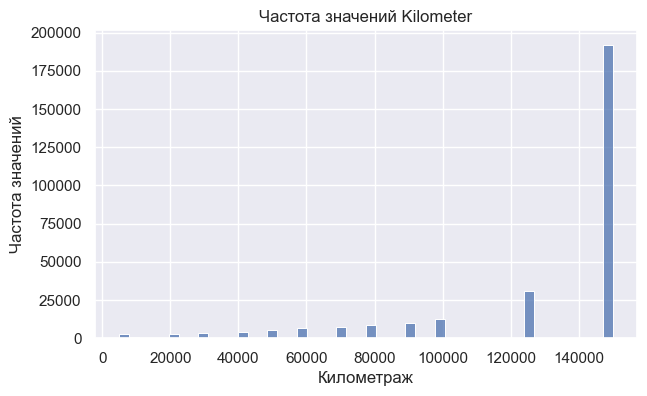

In [35]:
plt.figure(figsize=(7, 4)) 
sns.histplot(data=df, x='Kilometer', bins=50)
plt.title(f'Частота значений Kilometer')
plt.xlabel('Километраж')
plt.ylabel('Частота значений');

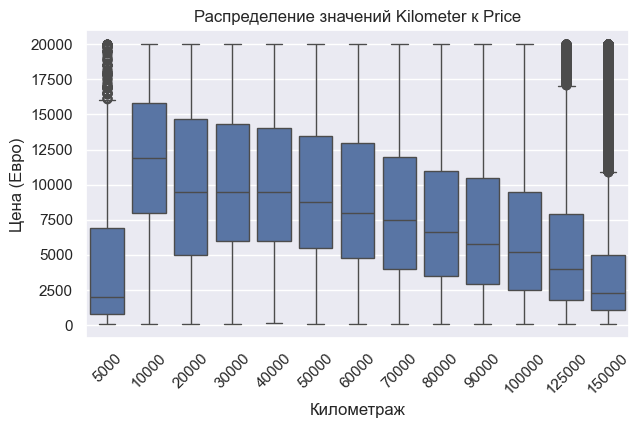

In [36]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='Kilometer', y='Price')
plt.title(f'Распределение значений Kilometer к Price')
plt.xlabel('Километраж')
plt.ylabel('Цена (Евро)')
plt.xticks(rotation=45);

### Топливо

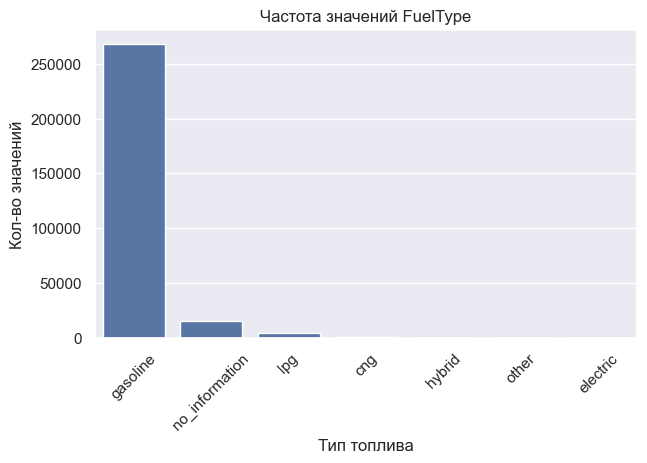

In [37]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x='FuelType', order=df.FuelType.value_counts().index)
plt.title(f'Частота значений FuelType')
plt.ylabel('Кол-во значений')
plt.xlabel('Тип топлива')
plt.xticks(rotation=45);

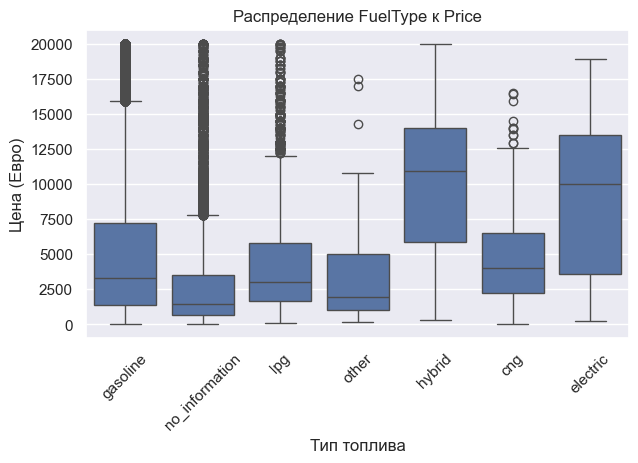

In [39]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='FuelType', y='Price')
plt.title(f'Распределение FuelType к Price')
plt.xlabel('Тип топлива')
plt.ylabel('Цена (Евро)')
plt.xticks(rotation=45);

### Бренд

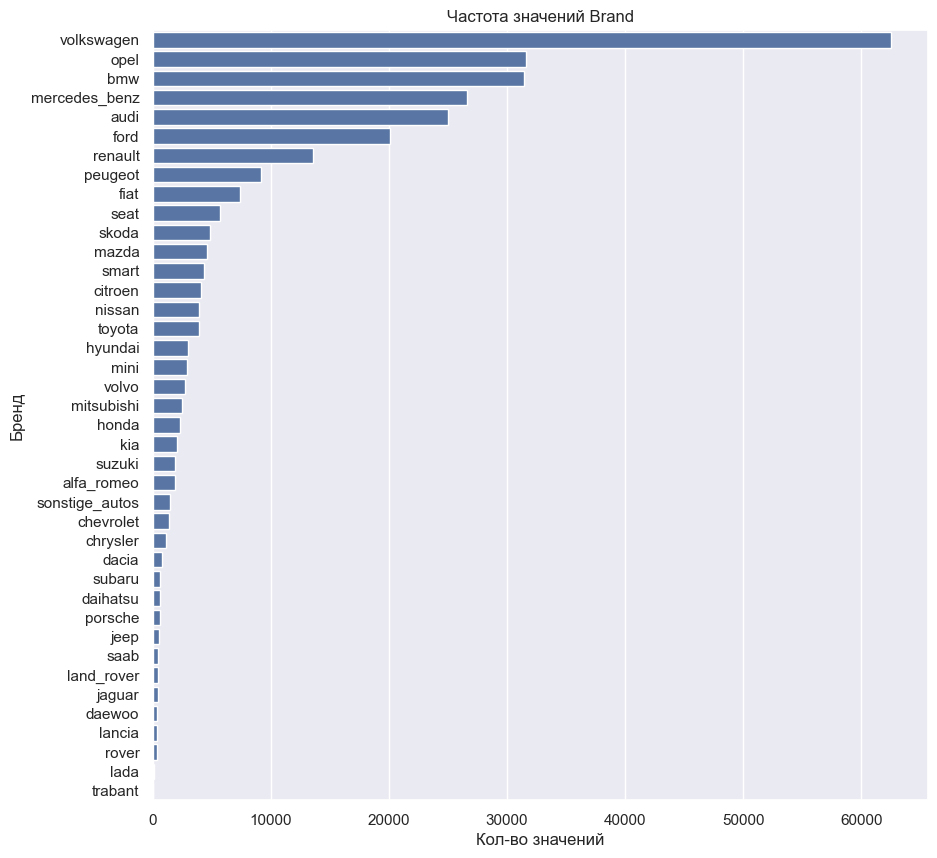

In [40]:
plt.figure(figsize=(10, 10))
sns.countplot(data=df, y='Brand', order=df.Brand.value_counts().index)
plt.title(f'Частота значений Brand')
plt.xlabel('Кол-во значений')
plt.ylabel('Бренд');

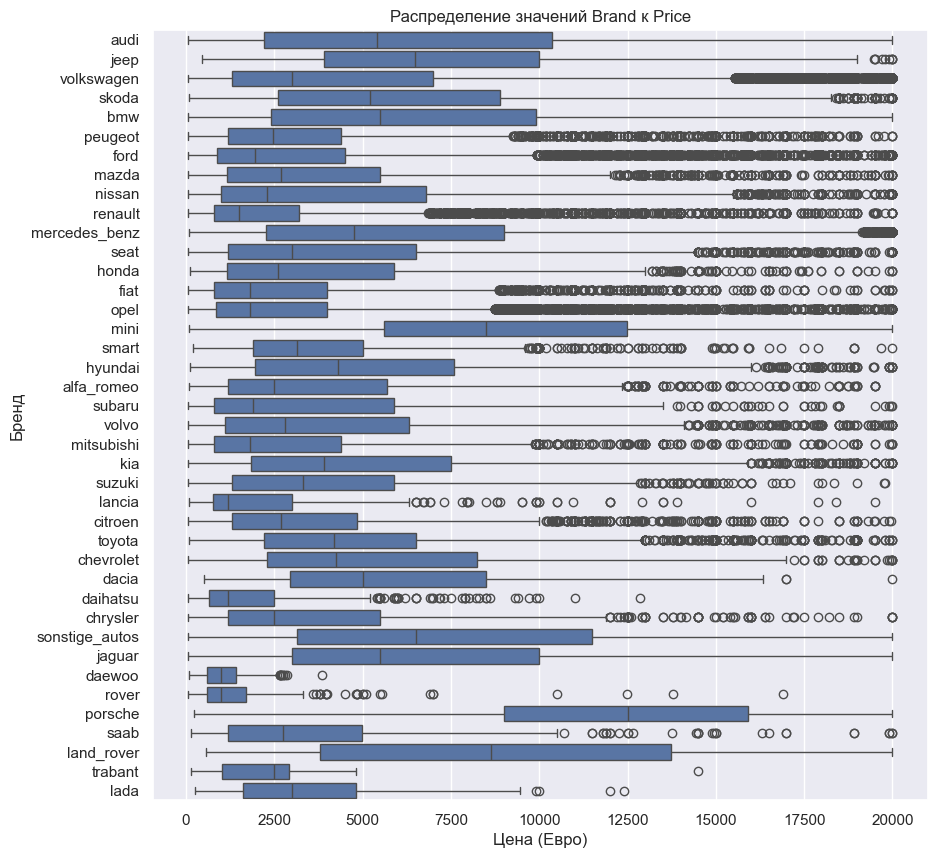

In [41]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y='Brand', x='Price')
plt.title(f'Распределение значений Brand к Price')
plt.ylabel('Бренд')
plt.xlabel('Цена (Евро)');

### Была машина в ремонте или нет

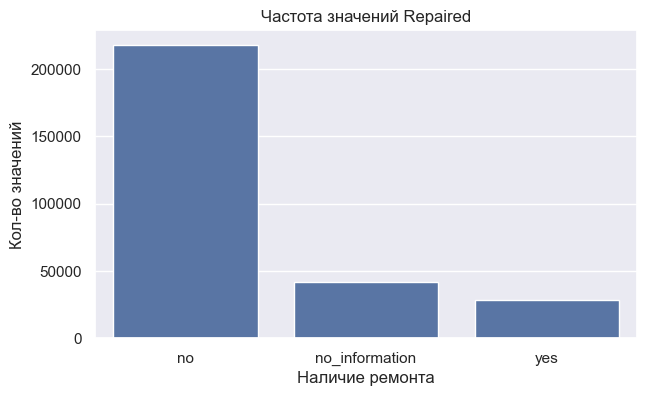

In [41]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x='Repaired', order=df.Repaired.value_counts().index)
plt.title(f'Частота значений Repaired')
plt.ylabel('Кол-во значений')
plt.xlabel('Наличие ремонта');

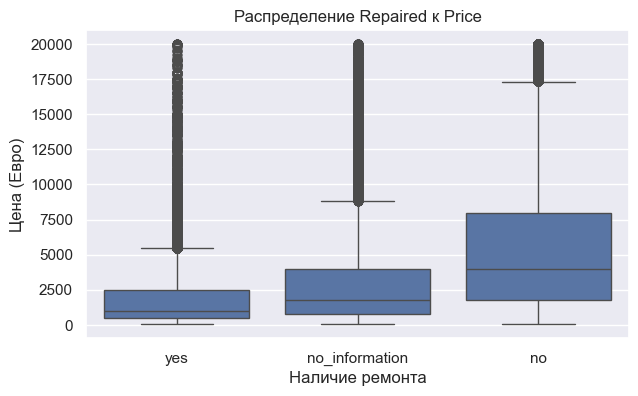

In [42]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='Repaired', y='Price')
plt.title(f'Распределение Repaired к Price')
plt.ylabel('Цена (Евро)')
plt.xlabel('Наличие ремонта');

## Корреляционный анализ данных

In [43]:
col_to_drop = ['NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth']

res = phik_matrix(df.drop(col_to_drop, axis=1), interval_cols=['Price', 'Power', 'Kilometer'])

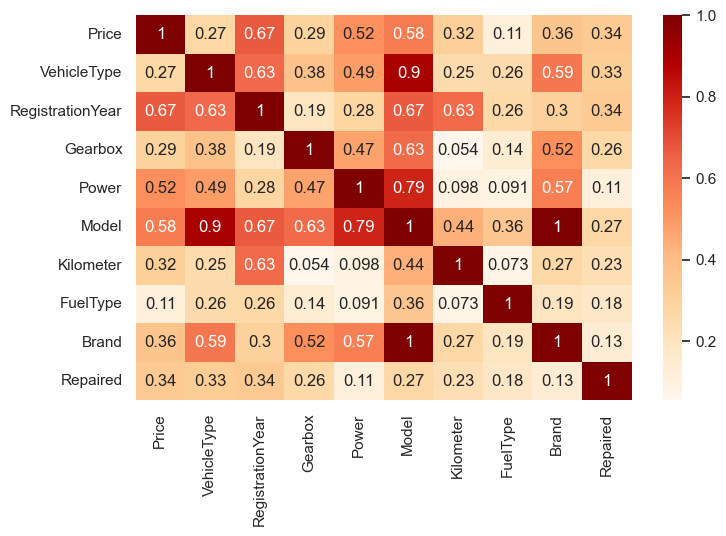

In [44]:
plt.figure(figsize=(8, 5))

sns.heatmap(res, annot=True, cmap='OrRd');

-- Наиболее коррелирующие признаки:

-- RegistrationYear -- 0.66

-- Power -- 0.51

-- Model -- 0.58

Чтобы избежать ухудшения обучаемости вследствии мультиколлинеарности признаков -- стоит убрать признак "Brand" (в частности изза его меньшей информативности по сравнению с "Model" - моделью машины)

In [45]:
df_cleared = df.drop(col_to_drop+['Brand'], axis=1)

In [46]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24,18300,coupe,2011,manual,190,no_information,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_information,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes,2016-04-04,0,33775,2016-04-06


In [47]:
df_cleared.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
1,18300,coupe,2011,manual,190,no_information,125000,gasoline,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,no_information
3,1500,small,2001,manual,75,golf,150000,gasoline,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,no
5,650,sedan,1995,manual,102,3er,150000,gasoline,yes


In [48]:
df_cleared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288081 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             288081 non-null  int64 
 1   VehicleType       288081 non-null  object
 2   RegistrationYear  288081 non-null  int64 
 3   Gearbox           288081 non-null  object
 4   Power             288081 non-null  int64 
 5   Model             288081 non-null  object
 6   Kilometer         288081 non-null  int64 
 7   FuelType          288081 non-null  object
 8   Repaired          288081 non-null  object
dtypes: int64(4), object(5)
memory usage: 22.0+ MB


## Подготовка данных

In [49]:
X = df_cleared.drop(['Price'], axis=1)
y = df_cleared.Price

In [50]:
X

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
1,coupe,2011,manual,190,no_information,125000,gasoline,yes
2,suv,2004,auto,163,grand,125000,gasoline,no_information
3,small,2001,manual,75,golf,150000,gasoline,no
4,small,2008,manual,69,fabia,90000,gasoline,no
5,sedan,1995,manual,102,3er,150000,gasoline,yes
...,...,...,...,...,...,...,...,...
354361,no_information,2016,auto,150,159,150000,no_information,no
354362,sedan,2004,manual,225,leon,150000,gasoline,yes
354366,convertible,2000,auto,101,fortwo,125000,gasoline,no
354367,bus,1996,manual,102,transporter,150000,gasoline,no


In [51]:
ohe_cols = ['Gearbox','Repaired']
num_cols = ['Power', 'Kilometer', 'RegistrationYear']
targ_cols = ['VehicleType', 'Model', 'FuelType']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42
)


num_pipe = Pipeline(steps=[
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('num', StandardScaler())
])

targ_pipe = Pipeline(steps=[
    ('simpleImputer_targ', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('target', TargetEncoder())
])

ohe_pipe = Pipeline(steps=[
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first'))
])



data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('ohe', ohe_pipe, ohe_cols),
        ('target', targ_pipe, targ_cols)
    ]
)


pipe_final = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [52]:
param_grid = [
    {
        'models': [CatBoostRegressor(random_state=42, verbose=1000)],
        'models__iterations': [100, 200],
        'models__depth': [6, 8],
        'models__learning_rate': [0.1, 0.2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LGBMRegressor(random_state=42, verbose=1, force_row_wise=True)],
        'models__num_leaves': [31, 63],
        'models__learning_rate': [0.1, 0.2],
        'models__n_estimators': [100, 200],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

## Обучение моделей

In [53]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [54]:
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 216060, number of used features: 10
[LightGBM] [Info] Start training from score 4841.207137


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleImputer_num',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('num',
                                                                                          StandardScaler())]),
                                                                         ['Power',
                                                                          'Kilometer',
                                                                          'RegistrationYear']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncode...
                                                MinMaxScaler()]},
                         {'models': [LGBMRegressor(force_row_wise=True,
                                                   random_state=42,
                                                   verbose=1)],
                          'models__learning_rate': [0.1, 0.2],
                          'models__n_estimators': [100, 200],
                          'models__num_leaves': [31, 63],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring='neg_root_mean_squared_error')

In [55]:
best_model = grid_search.best_estimator_

In [56]:
# Обучаем на тренировочных данных и трансформируем тестовые признаки 
data_preprocessor.fit(X_train, y_train)  
X_test_transformed = data_preprocessor.transform(X_test)

# Сборка трансформированных призаков перед использованием 
X_test_transformed = pd.DataFrame(X_test_transformed, columns=data_preprocessor.get_feature_names_out())

In [57]:
X_test_transformed.columns # Проверка

Index(['num__Power', 'num__Kilometer', 'num__RegistrationYear',
       'ohe__Gearbox_manual', 'ohe__Gearbox_no_information',
       'ohe__Repaired_no_information', 'ohe__Repaired_yes', 'target__0',
       'target__1', 'target__2'],
      dtype='object')

In [58]:
# Использование лучшей модели вручную
y_pred = grid_search.best_estimator_.named_steps['models'].predict(X_test_transformed)
y_error = y_test - y_pred # Расчёт ошибки прогноза

In [59]:
print(f"Средняя Метрика RMSE на тренировочных данных: {round(grid_search.best_score_, 1)*-1}")

Средняя Метрика RMSE на тренировочных данных: 1558.5


In [60]:
rmse_metric = mean_squared_error(y_test, y_pred) ** 0.5

print(f'Метрика RMSE на тестовых данных: {round(rmse_metric, 1)}')

Метрика RMSE на тестовых данных: 1571.6


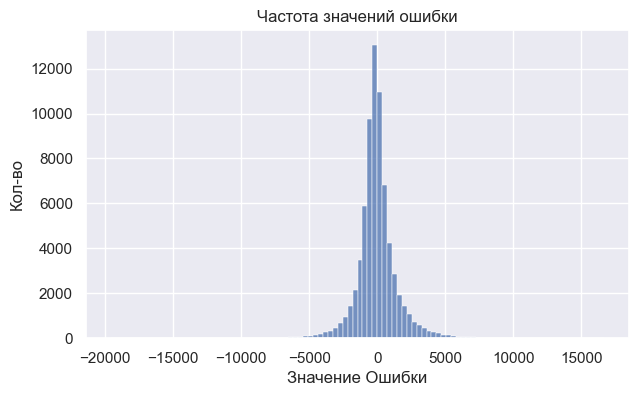

In [61]:
plt.figure(figsize=(7, 4))
sns.histplot(y_error, bins=100)
plt.title('Частота значений ошибки')
plt.xlabel('Значение Ошибки')
plt.ylabel('Кол-во');

In [62]:
result = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'y_error': y_error
})

In [63]:
result

,y_test,y_pred,y_error
303370,3590,3975.046435,-385.046435
331363,1999,1925.494206,73.505794
351022,4355,8225.317912,-3870.317912
2223,2290,2149.155245,140.844755
221932,4999,4416.550899,582.449101
...,...,...,...
23938,1275,562.781482,712.218518
174462,2200,2578.771755,-378.771755
250110,650,490.443974,159.556026
203129,5000,6078.379010,-1078.379010


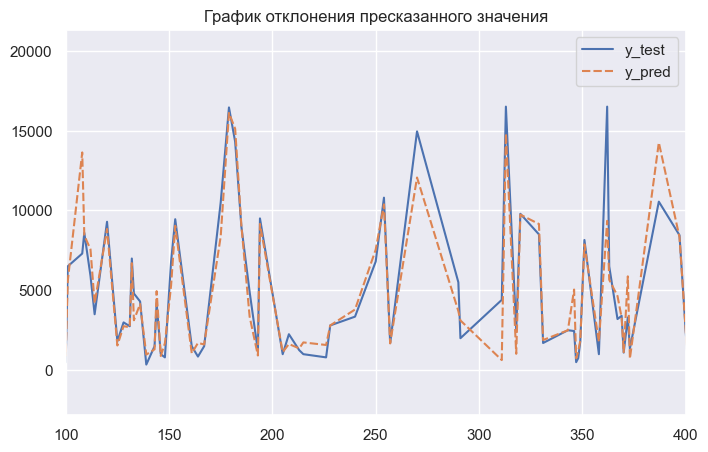

In [64]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(data=result[['y_test', 'y_pred']])
plt.title('График отклонения пресказанного значения')
ax.set_xlim(100, 400);

In [65]:
res = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
res[['rank_test_score', 'mean_fit_time', 'params', 'std_test_score']].head()

,rank_test_score,mean_fit_time,params,std_test_score
0,1,11.340556,"{'models': LGBMRegressor(force_row_wise=True, ...",15.078209
1,2,8.637368,"{'models': LGBMRegressor(force_row_wise=True, ...",15.171651
2,3,12.537921,"{'models': LGBMRegressor(force_row_wise=True, ...",14.674502
3,4,13.025148,"{'models': LGBMRegressor(force_row_wise=True, ...",15.906234
4,5,7.601254,"{'models': LGBMRegressor(force_row_wise=True, ...",15.543761


#### Анализ важности признаков

In [66]:
# оценка важности признаков через permutation_importance
result = permutation_importance(grid_search.best_estimator_.named_steps['models'], X_test_transformed, y_test, n_repeats=10, random_state=42)
importance = result.importances_mean
feature_names = X_test_transformed.columns


per_importance_df = pd.DataFrame(data={'Признак': feature_names,
                                       'Важность': np.around(importance, decimals=3)})

# важность признаков
per_importance_df.sort_values(by='Важность', ascending=False)

,Признак,Важность
2,num__RegistrationYear,0.712
0,num__Power,0.312
8,target__1,0.145
1,num__Kilometer,0.084
7,target__0,0.050
6,ohe__Repaired_yes,0.025
3,ohe__Gearbox_manual,0.005
5,ohe__Repaired_no_information,0.003
4,ohe__Gearbox_no_information,0.000
9,target__2,0.000


### Цель

Приложение должно предлагать точные и быстрые оценки, чтобы повысить доверие клиентов к сервису и привлечь новых клиентов.

### Результаты

- **CatBoost** показал отличное качество предсказания с RMSE, что ниже порогового значения 2500. Лучшие показатели относительно времени обучения, времени прогнозирования и ошибки модели.


- **LightGBM** продемонстрировал высочайшее качество предсказания с RMSE. Однако время обучения было самым длинным среди всех моделей, а время прогнозирования — чуть дольше, чем у CatBoost.


- **Линейная регрессия** обучалась и предсказывала очень быстро, но её точность оставляет желать лучшего, так как RMSE значительно превышает порог в 2500.

### На основании полученных результатов можно сделать следующие выводы:

- **LightGBM и CatBoost** предоставляют отличное качество предсказаний, соответствующее требованиям заказчика.


- **LightGBM** имеет преимущество по качеству обучения и прогнозирования, что делает его предпочтительным выбором среди моделей градиентного бустинга.


- **Линейная регрессия** не удовлетворяет требованиям по точности, хотя и является самой быстрой моделью по времени обучения и прогнозирования.

### Лучшая модель

Модель **LightGBM** была разработана и обучена для решения задачи оценки стоимости авто. На основе тщательно проведенного анализа и тестирования, модель продемонстрировала высокие показатели точности и надежности, что делает её готовой к внедрению в сервис.

**LightGBM** лучше всего подходит по быстродействию и точности для имплементации в сервис по продаже автомобилей.


In [67]:
# Объект лучшей модели
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Power', 'Kilometer',
                                                   'RegistrationYear']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('target',
                                                  Pipeline(steps=[('simpleImputer_targ',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target',
                                                                   TargetEncoder())]),
                                                  ['VehicleType', 'Model',
                                                   'FuelType'])])),
                ('models',
                 LGBMRegressor(force_row_wise=True, learning_rate=0.2,
                               n_estimators=200, num_leaves=63, random_state=42,
                               verbose=1))])

In [68]:
# Параметры лучшей модели
grid_search.best_params_

{'models': LGBMRegressor(force_row_wise=True, random_state=42, verbose=1),
 'models__learning_rate': 0.2,
 'models__n_estimators': 200,
 'models__num_leaves': 63,
 'preprocessor__num': StandardScaler()}